# Perform online segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../dev/
from dataset_creation_aprovis3d import aprovis3dDataset

/home/antoine/homhots/aprovhots/dev


In [3]:
import tonic, torch, os, pickle, copy, sys
from tqdm import tqdm
from hots.network import network
from hots.layer import mlrlayer
from hots.timesurface import timesurface
from hots.utils import apply_jitter, get_loader, get_dataset_info, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy, make_and_display_ts
import matplotlib.pyplot as plt
import imageio.v3 as iio
from IPython.display import Image
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/' #-> default if not mentionned

data_path = '../../Data/RGB_frames2events/'
# gives the data type - here we use experimental data, stored as npy

Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [4]:
data_type = 'synthetic'
# gives a patch_size to divide spatially the event streams
patch_size = (672, 376)
# gives a max duration for the samples of the dataset to divide temporally the event streams
max_duration = 1e3 # (in ms)
# labels given to the different classes of the dataset
labelz = ['sea','gro']
# original sensor_size of the DVS (width,height,polarity)
sensor_size = [672, 376, 2]
# discard samples with less than min_num_events events
min_num_events = 1000
# split the recordings into train and test sets with train_test_ratio ratio
train_test_ratio = .75
# gives the indexing of the event stream
ordering = 'xytp'

trainset = aprovis3dDataset(save_to=data_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)
testset = aprovis3dDataset(save_to=data_path, data_type=data_type, classes=labelz, train=False, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)
trainloader = get_loader(trainset)
testloader = get_loader(testset)

num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(trainset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 69
number of samples in the testing set: 24


## Run the core HOTS network

In [5]:
name = 'homeohots'
homeo = True
timestr = '2023-01-03'
dataset_name = 'aprovis_UCA_no_patch'
ts_batch_size = int(2e4)

tau_0 = 6e3
tau_0 = 2e4

Rz = [4, 8]
N_neuronz = [64, 16]
tauz = [tau_0*2, tau_0*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)

initial_name = hots.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists(record_path):
    os.mkdir(record_path)
    os.mkdir(record_path+'networks/')
    os.mkdir(record_path+'output/')
    os.mkdir(record_path+'output/train/')
    os.mkdir(record_path+'output/test/')
    os.mkdir(record_path+'LR_results/')
path = record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(trainloader, trainset.ordering, filtering_threshold = filtering_threshold, ts_batch_size = ts_batch_size)

In [6]:
hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = None, training=True, ts_batch_size = ts_batch_size, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = None, training=False, ts_batch_size = ts_batch_size, verbose=False)

In [7]:
jitter = (None, None)
type_transform = tonic.transforms.NumpyAsType(int)
train_path = record_path+f'output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = record_path+f'output/test/{hots.name}_{num_sample_test}_{jitter}/'
#trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
#testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)

## Divide the event streams into 16x16 patches

In [8]:
patch_size = (64, 64)
max_duration = None
min_num_events = 10
kfold = None

#weird way of splitting dataset between trainsets and testsets but works -> to improve
trainset_output = aprovis3dDataset(save_to=train_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size, train_test_ratio=1, min_num_events=min_num_events)
testset_output = aprovis3dDataset(save_to=test_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size, train_test_ratio=1, min_num_events=min_num_events)
trainloader_output = get_loader(trainset_output, kfold = kfold)
testloader_output = get_loader(testset_output)
print(f'number of samples in the training set: {len(trainloader_output)}')
print(f'number of samples in the testing set: {len(testloader_output)}')

number of samples in the training set: 3218
number of samples in the testing set: 1172


## Example with only one layer of Multinomial Logistic Regression (MLR)

In [9]:
ts_batch_size = int(1e3) 
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
betas = (0.9, 0.999)
num_epochs = 2 ** 5 + 1
N_polarities = N_neuronz[-1]
ts_size = (trainset_output.sensor_size[0],trainset_output.sensor_size[1],N_polarities)
tau_cla = 6e4*32
mlr_layer_name = f'{timestr}_LR_patches_{tau_cla}_{ts_size}_{learning_rate}_{betas}_{num_epochs}_{kfold}_{jitter}.pkl'

model_path = record_path+'networks/' + mlr_layer_name
results_path = record_path+'LR_results/' + mlr_layer_name
train_path = record_path+f'output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = record_path+f'output/train/{hots.name}_{num_sample_test}_{jitter}/'

classif_layer, losses = fit_mlr(trainloader_output, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), ts_batch_size = ts_batch_size,)

Number of chance decisions: 0
90th quantile for number of events: 11507.200000000008
Mean accuracy: 68.10000000000001%
Last accuracy: 61.3%
Highest probability accuracy: 56.10000000000001%


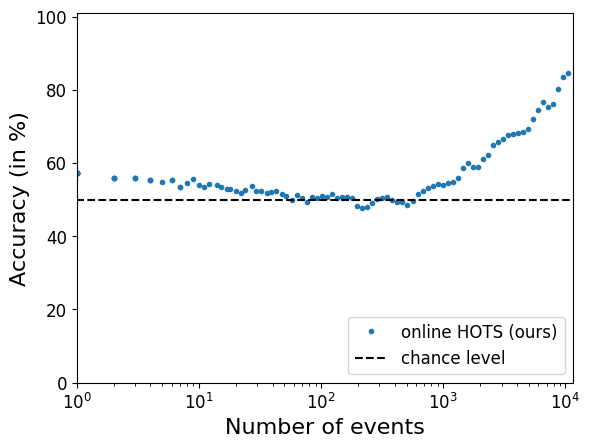

In [10]:
mlr_threshold = None

onlinac = online_accuracy(classif_layer, tau_cla, testloader_output, results_path, ts_size, trainset.ordering, len(labelz), mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, original_accuracy = None, original_accuracy_nohomeo = None, online_plot=True)

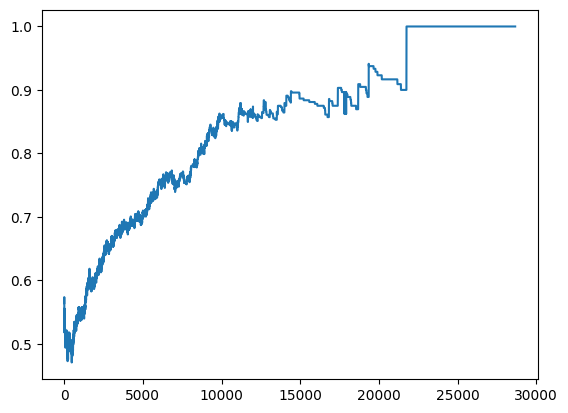

In [11]:
plt.plot(onlinac[0])